In [7]:
import spacy
# import crosslingual_coreference

c:\Users\layas\anaconda3\envs\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
import sys
print(sys.executable)


c:\Users\layas\anaconda3\envs\Python310\python.exe


In [9]:
# Add rebel component https://github.com/Babelscape/rebel/blob/main/spacy_component.py
import requests
import re
import hashlib
from spacy import Language
from typing import List

from spacy.tokens import Doc, Span

from transformers import pipeline

def call_wiki_api(item):
  try:
    url = f"https://www.wikidata.org/w/api.php?action=wbsearchentities&search={item}&language=en&format=json"
    data = requests.get(url).json()
    # Return the first id (Could upgrade this in the future)
    return data['search'][0]['id']
  except:
    return 'id-less'

def extract_triplets(text):
    """
    Function to parse the generated text and extract the triplets
    """
    triplets = []
    relation, subject, relation, object_ = '', '', '', ''
    text = text.strip()
    current = 'x'
    for token in text.replace("<s>", "").replace("<pad>", "").replace("</s>", "").split():
        if token == "<triplet>":
            current = 't'
            if relation != '':
                triplets.append({'head': subject.strip(),
                                 'type': relation.strip(),
                                 'tail': object_.strip()})
                relation = ''
            subject = ''
        elif token == "<subj>":
            current = 's'
            if relation != '':
                triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
            object_ = ''
        elif token == "<obj>":
            current = 'o'
            relation = ''
        else:
            if current == 't':
                subject += ' ' + token
            elif current == 's':
                object_ += ' ' + token
            elif current == 'o':
                relation += ' ' + token
    if subject != '' and relation != '' and object_ != '':
        triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
    return triplets


@Language.factory(
    "rebel",
    requires=["doc.sents"],
    assigns=["doc._.rel"],
    default_config={
        "model_name": "Babelscape/rebel-large",
        "device": 0,
    },
)
class RebelComponent:
    def __init__(
        self,
        nlp,
        name,
        model_name: str,
        device: int,
    ):        
        assert model_name is not None, ""
        self.triplet_extractor = pipeline("text2text-generation", model=model_name, tokenizer=model_name, device=device)
        self.entity_mapping = {}
        # Register custom extension on the Doc
        if not Doc.has_extension("rel"):
          Doc.set_extension("rel", default={})

    def get_wiki_id(self, item: str):
        mapping = self.entity_mapping.get(item)
        if mapping:
          return mapping
        else:
          res = call_wiki_api(item)
          self.entity_mapping[item] = res
          return res

    def _generate_triplets(self, sent: Span) -> List[dict]:
        output_ids1 = self.triplet_extractor(sent.text, return_tensors=True, return_text=False)[0]["generated_token_ids"]["output_ids"]
        extracted_text1 = self.triplet_extractor.tokenizer.batch_decode(output_ids1[0])
        extracted_triplets1 = extract_triplets(extracted_text1[0])
        return extracted_triplets1
 

    def set_annotations(self, doc: Doc, triplets: List[dict]):
        for triplet in triplets:
            # Remove self-loops (relationships that start and end at the entity)
            if triplet['head'] == triplet['tail']:
                continue

            # Use regex to search for entities
            head_span = re.search(triplet["head"], doc.text)
            tail_span = re.search(triplet["tail"], doc.text)

            # Skip the relation if both head and tail entities are not present in the text
            # Sometimes the Rebel model hallucinates some entities
            if not head_span or not tail_span:
              continue

            index = hashlib.sha1("".join([triplet['head'], triplet['tail'], triplet['type']]).encode('utf-8')).hexdigest()
            if index not in doc._.rel:
                # Get wiki ids and store results
                doc._.rel[index] = {"relation": triplet["type"], "head_span": {'text': triplet['head'], 'id': self.get_wiki_id(triplet['head'])}, "tail_span": {'text': triplet['tail'], 'id': self.get_wiki_id(triplet['tail'])}}

    def __call__(self, doc: Doc) -> Doc:
        for sent in doc.sents:
            sentence_triplets = self._generate_triplets(sent)
            self.set_annotations(doc, sentence_triplets)
        print("Doc:",doc)
        return doc

In [10]:
# Add coreference resolution model
coref = spacy.load('en_core_web_sm', disable=['ner', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer'])
coref.add_pipe(
    "xx_coref", config={"chunk_size": 2500, "chunk_overlap": 2, "device": -1})

# Define rel extraction model

rel_ext = spacy.load('en_core_web_sm', disable=['ner', 'lemmatizer', 'attribute_rules', 'tagger'])
rel_ext.add_pipe("rebel", config={
    'device':-1, # Number of the GPU, -1 if want to use CPU
    'model_name':'Babelscape/rebel-large'} # Model used, will default to 'Babelscape/rebel-large' if not given
    )


[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\layas\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\layas\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
error loading _jsonnet (this is expected on Windows), treating C:\Users\layas\AppData\Local\Temp\tmpohnd_fya\config.json as plain json
Some weights of the model checkpoint at nreimers/mMiniLMv2-L12-H384-distilled-from-XLMR-Large were not used when initializing XLMRobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRoberta

In [11]:
import PyPDF2 as pdf

def extract_text_from_pdf(pdf_path, page_number):
    with open(pdf_path, 'rb') as file:
        pdf_reader = pdf.PdfReader(file)
        page = pdf_reader.pages[page_number - 1]  # Adjusting for 0-based indexing
        text = page.extract_text() # Remove '\n' characters
        return text

pdf_path = 'Dataset\DEWA Sustainability Report 2022.pdf'
page_number = 6  # Example page number
extracted_text = extract_text_from_pdf(pdf_path, page_number)
print(extracted_text)


At Dubai Electricity and Water Authority (DEWA), 
we work to achieve the wise vision of His Highness 
Sheikh Mohamed bin Zayed Al Nahyan, President 
of the UAE; and His Highness Sheikh Mohammed 
bin Rashid Al Maktoum, Vice President and Prime 
Minister of the UAE and Ruler of Dubai, to enhance 
sustainability and the shift towards a diversified and 
green economy. Sustainability is an integral part of 
our vision and strategy in line with the strategies of 
Dubai and the UAE. We are the first government 
organisation to adopt sustainability in its strategic 
plan to achieve long-term sustainability goals and the 
17 UN Sustainable Development Goals (SDGs) 2030 
and promote the sustainable green growth and the 
economic, environmental, and social sustainability.
We are committed to the best effective governance 
practices within an integrated framework, in 
addition to regularly reviewing all our activities 
and operations to keep pace with the rapid 
developments and enhance DEWA’s agi

In [12]:
input_text = extracted_text

coref_text = coref(input_text)._.resolved_text

doc = rel_ext(coref_text)
for value, rel_dict in doc._.rel.items():
    print(f"{rel_dict}")


Doc: At Dubai Electricity and Water Authority (DEWA), 
DEWA’s work to achieve the wise vision of His Highness 
Sheikh Mohamed bin Zayed Al Nahyan, President 
of the UAE; and His Highness Sheikh Mohammed 
bin Rashid Al Maktoum, Vice President and Prime 
Minister of the UAE and Ruler of Dubai, to enhance 
sustainability and the shift towards a diversified and 
green economy. Sustainability is an integral part of 
DEWA’s's vision and strategy in line with the strategies of 
Dubai and the UAE. DEWA’s are the first government 
organisation to adopt sustainability in DEWA’s's strategic 
plan to achieve long-term sustainability goals and the 
17 UN Sustainable Development Goals (SDGs) 2030 
and promote the sustainable green growth and the 
economic, environmental, and social sustainability.
DEWA’s are committed to the best effective governance 
practices within an integrated framework, in 
addition to regularly reviewing all DEWA’s's activities 
and operations to keep pace with the rapid 
dev

In [13]:
source=[]
target=[]
edge=[]
# Extract data from the dictionaries
for rel_dict in doc._.rel.items():
    print(rel_dict)
    source.append(rel_dict[1]['head_span']['text'])
    target.append(rel_dict[1]['tail_span']['text'])
    edge.append(rel_dict[1]['relation'])

# Create DataFrame

('962a4ef78db322e2f710035e1247abe31fd277f5', {'relation': 'country', 'head_span': {'text': 'Dubai Electricity and Water Authority', 'id': 'Q1262868'}, 'tail_span': {'text': 'UAE', 'id': 'Q878'}})
('b97d6127f28748b2e92f36eb16db48d982dd0c1c', {'relation': 'country of citizenship', 'head_span': {'text': 'Mohamed bin Zayed Al Nahyan', 'id': 'Q1951896'}, 'tail_span': {'text': 'UAE', 'id': 'Q878'}})
('2810d87b9dcd834de4c7879c6a14307a27f7474b', {'relation': 'head of state', 'head_span': {'text': 'UAE', 'id': 'Q878'}, 'tail_span': {'text': 'Mohamed bin Zayed Al Nahyan', 'id': 'Q1951896'}})
('4272c1cd489a4a1769c01cf6dadffaec700c84cd', {'relation': 'country', 'head_span': {'text': 'Dubai', 'id': 'Q612'}, 'tail_span': {'text': 'UAE', 'id': 'Q878'}})
('1f7cdeed53f076cdc542440c929e518043796d32', {'relation': 'part of', 'head_span': {'text': 'DEWA', 'id': 'Q759430'}, 'tail_span': {'text': 'DEWA’s', 'id': 'Q170138'}})
('ae8b81da054ae59cc4f6129b1163136685226acc', {'relation': 'creator', 'head_span': {

NameError: name 'pd' is not defined

In [14]:
import pandas as pd
kg_df = pd.DataFrame({'source': source, 'target': target, 'edge': edge})


In [15]:
kg_df

,source,target,edge
0,Dubai Electricity and Water Authority,UAE,country
1,Mohamed bin Zayed Al Nahyan,UAE,country of citizenship
2,UAE,Mohamed bin Zayed Al Nahyan,head of state
3,Dubai,UAE,country
4,DEWA,DEWA’s,part of
5,Sustainable Development Goals,UN,creator
6,governance,operations,part of
7,environmental,social,subclass of
8,DEWA,sustainability,field of work
9,policies and plans,strategies,has part


In [16]:
import networkx as nx

G=nx.from_pandas_edgelist(kg_df, "source", "target",
                          edge_attr=True, create_using=nx.MultiDiGraph())


In [17]:
label={}
for i in range(len(source)):
    label[(source[i],target[i])]=edge[i]

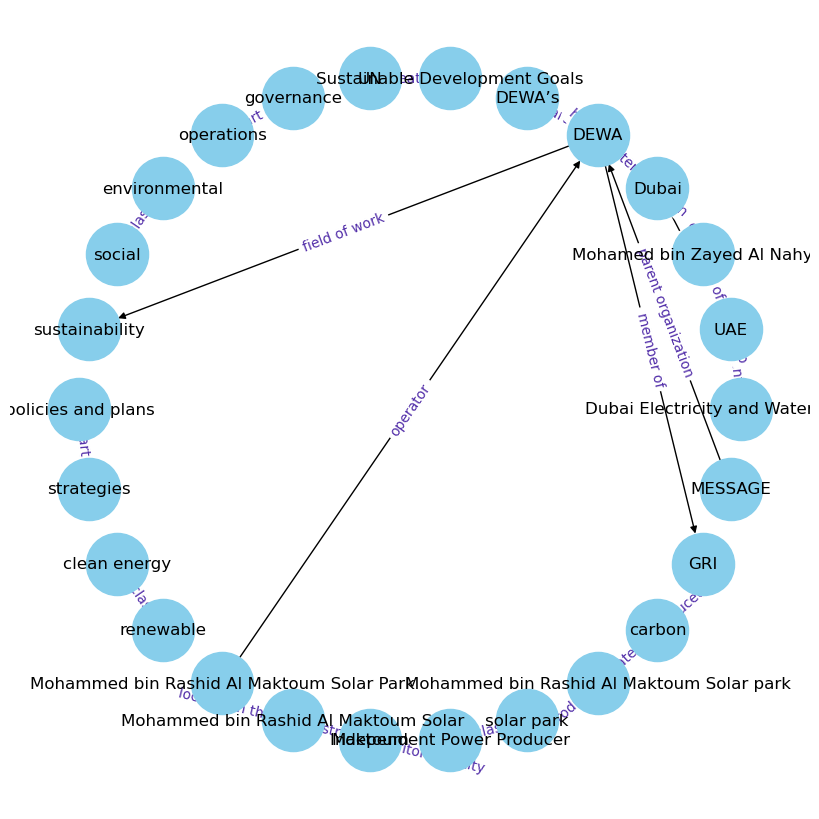

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))

pos = nx.circular_layout(G, scale=5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=2000, edge_cmap=plt.cm.Blues, pos = pos)

nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels=label,
    font_color='#512da8'
)
plt.show()

In [ ]:
import pandas as pd
import wikipedia
from neo4j import GraphDatabase

# Define Neo4j connection
host = 'neo4j://localhost:7687'
user = 'neo4j'
password = 'Gvi8ygPRAS3GMP2kplWDpWO12HtEbNH2o1lOnfiF1O4'
driver = GraphDatabase.driver(host,auth=(user, password))

import_query = """
UNWIND $data AS row
MERGE (h:Entity {id: CASE WHEN NOT row.head_span.id = 'id-less' THEN row.head_span.id ELSE row.head_span.text END})
ON CREATE SET h.text = row.head_span.text
MERGE (t:Entity {id: CASE WHEN NOT row.tail_span.id = 'id-less' THEN row.tail_span.id ELSE row.tail_span.text END})
ON CREATE SET t.text = row.tail_span.text
WITH row, h, t
CALL apoc.merge.relationship(h, toUpper(replace(row.relation,' ', '_')),
  {},
  {},
  t,
  {}
)
YIELD rel
RETURN distinct 'done' AS result;
"""


def run_query(query, params={}):
    with driver.session() as session:
        result = session.run(query, params)
        return pd.DataFrame([r.values() for r in result], columns=result.keys())

def kg():
  params = [rel_dict for value, rel_dict in doc._.rel.items()]
  run_query(import_query, {'data': params})
  

In [ ]:
kg()

Unable to retrieve routing information


ServiceUnavailable: Unable to retrieve routing information

In [ ]:
run_query("""
CALL apoc.periodic.iterate("
  MATCH (e:Entity)
  WHERE e.id STARTS WITH 'Q'
  RETURN e
","
  // Prepare a SparQL query
  WITH 'SELECT * WHERE{ ?item rdfs:label ?name . filter (?item = wd:' + e.id + ') filter (lang(?name) = \\"en\\") ' +
     'OPTIONAL {?item wdt:P31 [rdfs:label ?label] .filter(lang(?label)=\\"en\\")}}' AS sparql, e
  // make a request to Wikidata
  CALL apoc.load.jsonParams(
    'https://query.wikidata.org/sparql?query=' + 
      sparql,
      { Accept: 'application/sparql-results+json'}, null)
  YIELD value
  UNWIND value['results']['bindings'] as row
  SET e.wikipedia_name = row.name.value
  WITH e, row.label.value AS label
  MERGE (c:Class {id:label})
  MERGE (e)-[:INSTANCE_OF]->(c)
  RETURN distinct 'done'", {batchSize:1, retry:1})
""")

ServiceUnavailable: Couldn't connect to 192.168.0.160:7687 (resolved to ()):
Failed to establish connection to ResolvedIPv4Address(('192.168.0.160', 7687)) (reason [WinError 10061] No connection could be made because the target machine actively refused it)

In [ ]:
import socket

def get_ip_address():
    try:
        # Create a socket object
        s = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
        
        # Connect to any remote server, it doesn't matter which one
        s.connect(("8.8.8.8", 80))
        
        # Get the local IP address of the machine
        ip_address = s.getsockname()[0]
        
        return ip_address
    except Exception as e:
        print("Error:", e)
        return None

# Get the IP address
ip_address = get_ip_address()
if ip_address:
    print("IP Address:", ip_address)
else:
    print("Failed to retrieve IP address.")


IP Address: 192.168.0.160
